# Introduction

This exercise solution is built on top of [this blog post by Hashir Ahmad](https://hash-ir.github.io/2020/05/17/bike-sharing-patterns/). This exercise will provide a step by step guide to building a multilayer perceptron to predict the count of rental bike usage given various features.


The python packages we will be using are:

[NumPy](https://numpy.org/): Powerful tool to work with N-dimensional arrays
 
[Pandas](https://pandas.pydata.org/): Data analysis and manipulation tool

[Matplotlib](https://matplotlib.org/): Visualization tool

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

Real data is always dirty! Before we can do any machine learning, we need to process the data so that it is in good shape for training our model. 

## Raw Data
Lets take a look at the data we will be working with, it is taken from the [University of California Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#), it contains the count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. Each data entry contains information for one hour of data and there are 17379 entries in total. 



In [40]:
# read the raw data into a pandas dataframe
data_path = "https://raw.githubusercontent.com/xuwil/99-ML-Learning-Projects/development/011/data/"

raw_df = pd.read_csv(data_path + 'hour.csv')

# take a look at the shape of our raw data, there are 17379 entries and each entry contains 17 fields
raw_df.shape

(17379, 17)

In [ ]:
raw_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


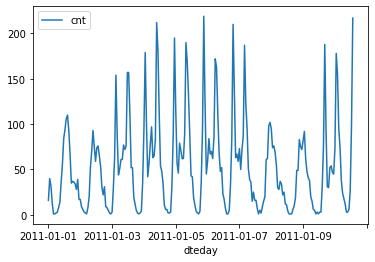

In [44]:
raw_df[:24*10].plot(x='dteday', y='cnt')


It has the following fields:
```
instant: record index
dteday : date
season : season (1:winter, 2:spring, 3:summer, 4:fall)
yr : year (0: 2011, 1:2012)
mnth : month ( 1 to 12)
hr : hour (0 to 23)
holiday : weather day is holiday or not
weekday : day of the week (0 to 6)
workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
hum: Normalized humidity. The values are divided to 100 (max)
windspeed: Normalized wind speed. The values are divided to 67 (max)
casual: count of casual users
registered: count of registered users
cnt: count of total rental bikes including both casual and registered
```
Our goal is to predict the count of bike rentals (ie. casual, registered, cnt) given the other fields (features). 

## Unused Features

Is every feature useful in making this prediction? Consider:

**instant:** the record index does not provide any useful information about the count of bike rentals

**dteday:** the date does not contribute to the count of bike rentals, the information it offers is captured in the other features (if the date is a holiday,if the date is a weekday or a weekend)

**atemp:** the information this field offers is captured in the `temp` feature.

**workingday:** the information this field offers is captured int the `weekday` and `holiday` features.

Since these features offers no information (or duplicate information) for predicting the count of bike rentals, we first want to clean up the data by removing them.

In [ ]:
unused_features = ['instant', 'dteday', 'atemp', 'workingday']
processed_df = raw_df.drop(unused_features, axis=1)  # drop the unused features
processed_df.head()

,season,yr,mnth,hr,holiday,weekday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,1,0.24,0.81,0.0,3,13,16
1,1,0,1,1,0,6,1,0.22,0.80,0.0,8,32,40
2,1,0,1,2,0,6,1,0.22,0.80,0.0,5,27,32
3,1,0,1,3,0,6,1,0.24,0.75,0.0,3,10,13
4,1,0,1,4,0,6,1,0.24,0.75,0.0,0,1,1


## Categorical Features
Is the data ready to be used now? 

Consider the feature `mnth` which has values from 1 - 12 representing Janurary to December. The integer values have a natural ordered relationship between each other. However, should Feburary be ranked higher than January?  

No, no such ordinal relationship exists between each month. Therefore,
we cannot use them as is, we need to turn them into one-hot encoded form.

Other features that needs to be one-hot encoded includes:
`season, weathersit, hr, weekday`

[Further Reading on Categorical Features](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)


In [ ]:
# There are many ways to implement one hot encoding:
# 1. using numpy
def numpy_one_hot(df, features_to_encode):
  """
  transform categorical data from 0-n into one-hot encoded form
  https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy

  uses https://numpy.org/doc/stable/reference/generated/numpy.eye.html
  np.eye(3) = [[1., 0., 0.],
               [0., 1., 0.],
               [0., 0., 1.]]
  np.eye(3)[[1,1,1,0]] = [[0., 1., 0.],
                          [0., 1., 0.],
                          [0., 1., 0.],
                          [1., 0., 0.]]
  """
  # this method only works when the categorical data is valued from 0 to n
  # we need to adjust season, weathersit, mnth
  adjust_categorical_features = ["season", "weathersit", "mnth"]

  for feature in features_to_encode:
    num_categories = len(processed_df[feature].unique())
    if feature in adjust_categorical_features:
      targets = processed_df[feature].values - 1
    else: 
      targets = processed_df[feature].values
    print(feature)
    one_hot_targets = np.eye(num_categories)[targets]

    # add the one hot encoded feature back into the dataframe
    df[["{}_{}".format(feature,i) for i in range(num_categories)]] = pd.DataFrame(one_hot_targets, index=df.index)
  return df

# 2. using pandas
def pandas_one_hot(df, features_to_encode):
  """
  pandas function to transform categorical data to one-hot
  https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
  """
  for feature in categorical_features:
    dummies = pd.get_dummies(df[feature], prefix=feature, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
  return df

# 3. using sklearn
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [ ]:
# identify the features that needs to be one-hot encoded
categorical_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']  

# processed_df = numpy_one_hot(processed_df, categorical_features)
processed_df = pandas_one_hot(processed_df, categorical_features)

# we can now drop the categorical features since they are no longer needed
processed_df = processed_df.drop(categorical_features, axis=1)
processed_df.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Continuous Features
Is the data ready to be used now? Consider:

`temp`: 30 degrees is larger than 20 degrees

`windspeed`: 15 m/s is larger than 10 m/s

However, the range of the two features are different. In extreme cases, one feature has range so large that it will dominate the other features. Therefore, we need to perform feature scaling. In our case, we will perform standardization  so that each feature has values with mean of 0 and standard deviation of 1.

[Further Reading on Feature Scaling](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)


In [ ]:
# identify contiunous fields that needs to be standardized
continuous_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# create mapping to revert values in later steps
scaled_features = {}
for feature in continuous_features:
    mean, std = processed_df[feature].mean(), processed_df[feature].std() # calculate mean and standard deviation of the feature
    scaled_features[feature] = [mean, std]  # store the values
    processed_df.loc[:, feature] = (processed_df[feature] - mean)/std # standardized values 

processed_df.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3,weathersit_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Train, Validation, Test split

One crucial step remains before our data is ready to be used for machine learning. 

We can not use the same data to train and to evaluate the model, since the model can simply remember the entire dataset and fail to [generalize](https://deepai.space/what-is-generalization-in-machine-learning/). Therefore, we need to split the data into three seperate sets.

**Training Set** will be used to train the model.

**Validation Set** will be used to tune the hyper parameters (Will be covered in a later section)

**Test Set** will be used to evaluate the model's true performance on data that it has not seen before.

We will split our data 70%|20%|10% for Train|Validation|Test


[Further Reading on Dataset Split](https://machinelearningmastery.com/difference-test-validation-datasets/)



In [ ]:
# determine the number of entries in each set
total_entries = processed_df.shape[0]
train_entries = int(total_entries * 0.7)
val_entries = int(total_entries * 0.2)

# Split dataframe into train, validation and test
train_data = processed_df[:train_entries]
validation_data = processed_df[train_entries:train_entries+val_entries]
test_data = processed_df[train_entries+val_entries:]

# Separate the data into features and targets
label_fields = ['cnt', 'casual', 'registered']
train_features, train_labels = train_data.drop(label_fields, axis=1), train_data[label_fields]
validation_features, validation_labels = validation_data.drop(label_fields, axis=1), validation_data[label_fields]
test_features, test_targets = test_data.drop(label_fields, axis=1), test_data[label_fields]

In [ ]:
train_features.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_labels.head()

,cnt,casual,registered
0,-0.956312,-0.662736,-0.930162
1,-0.823998,-0.561326,-0.804632
2,-0.868103,-0.622172,-0.837666
3,-0.972851,-0.662736,-0.949983
4,-1.039008,-0.723582,-1.009445


In [ ]:
train_features.shape

(12165, 56)

In the end, we have 12165 entries to train our model with, each entry contains 56 features

# Multi Layer Perceptron


## Overview
Now that we have the data, how do we turn the features into a prediction?

We will be using a simple multilayer perceptron. It will take in the 56 features and output a predicted label `cnt`.

The simple MLP we will be constructing looks something like

<img src="assets/MLP_overview.png">

The 56 features are fed into the MLP as inputs, they will be processed through a hidden layer (size to be determined) and a prediction will be produced through a output layer of size 1. 

Let's take a closer look at one hidden layer node.

<img src="assets/single_node.png">

The output of this node is obtained by finding the dot product between the input vector and the weights vector, and then putting the results through an activation function $\phi$

\begin{equation*}
h = \phi \left( \sum_{i=1}^{56}x_i w_i \right)
\end{equation*}

[Further Reading on MLP](https://machinelearningmastery.com/neural-networks-crash-course/)


## Activation Functions

The activation function $\phi$ is a mathematical “gate” that transforms the dot product of input vector and weights vector into an output going to the next layer. Non-linear activation functions allows the model to learn much more complex data, since the hypothesis space for the model becomes non-linear.

A few of the most commonly used activation functions will be briefly introduced below.

[Further Reading on Activation Functions](https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e)



In [ ]:
def visualize(activation_function):
  # helper function to visualize activation functions 
  # https://stackoverflow.com/a/42170061
  x = np.arange(-10, 10, 0.1)
  val = activation_function(x)
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  ax.spines['left'].set_position(('data', 0.0))
  ax.spines['bottom'].set_position(('data', 0.0))
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')
  plt.plot(x,val)
  plt.title("{} activation function".format(activation_function.__name__))
  plt.show()

### 1.ReLU

Rectified Linear Unit(ReLU) has output 0 if the input is less than 0, and raw output otherwise. 

\begin{equation*}
ReLU(x) = max(0, x)
\end{equation*}

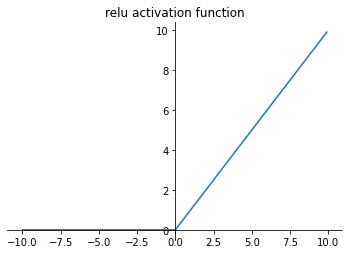

In [ ]:
def relu(x): 
    return np.maximum(0,x)

visualize(relu)

### 2.Leaky ReLU 

Leaky ReLU is a modified version of ReLU. It has a small slope for negative values defined by parameter $\alpha$, instead of zero. This gives an indication of how wrong the perdiction was which ReLu lacks.

\begin{equation}
  LeakyReLU(x) =
    \begin{cases}
      \alpha x & \text{if } x < 0\\
      x & \text{if } x > 0\\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

[Further Reading on ReLU vs Leaky ReLU](https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7)

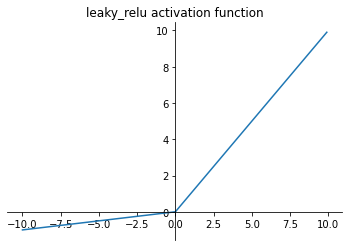

In [ ]:
def leaky_relu(x):
  alpha = 0.1
  return np.where(x > 0, x, x * alpha)

visualize(leaky_relu)

### 3.Sigmoid
Sigmoid function output a number between 0 and 1. 
If the input is very negative, the output is approximately 0. If the input is very positive, the output is approximately 1. If the input is 0, the output is 0.5

\begin{equation*}
Sigmoid(x) = \frac{1}{1 + e^{-x}}
\end{equation*}

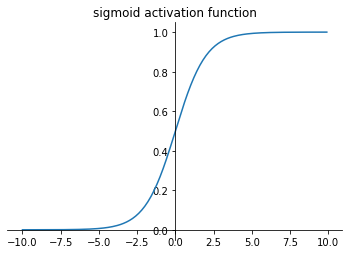

In [ ]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

visualize(sigmoid)

### 4.Tanh

Tanh function is a scaled version of the sigmoid function, it outputs a number between -1 and 1 instead. 
If the input is very negative, the output is approximately -1. If the input is very positive, the output is approximately 1. If the input is 0, the output is 0.

\begin{equation*}
Tanh(x) = \frac{2}{1 + e^{-2x}} -1
\end{equation*}

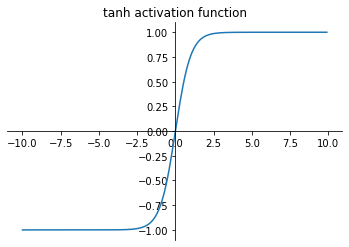

In [ ]:
def tanh(x): 
    return np.tanh(x)

visualize(tanh)

## Initialization

We will be initializing our weights using the Xavier Initialization:
\begin{equation*}
W \sim \mathcal{N}(\mu = 0,\,\sigma^{2} = \frac{1}{\text{previous layer size}})\,.
\end{equation*}

[Further Reading on Weight Initialization](https://www.deeplearning.ai/ai-notes/initialization/)

In [ ]:
# Initialize our Multilayer Perceptron
class MLP(object):
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        # np.random.normal takes the standard deviation as input, so we take the square root of layer size
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_size**-0.5, 
                                       (self.input_size, self.hidden_size))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_size**-0.5, 
                                       (self.hidden_size, self.output_size))
        
        # Initialize learning rate (see later section)
        self.learning_rate = learning_rate
        
        # Sigmoid activation function
        self.activation_function = sigmoid

# Learning Process

Now its time to start looking at how the the weights are optimized. A high level explanation of this that the training is fed into the initialized model and the output is compared to the known values. The comparing is down using what is known as a loss function, discussed later, this returns an indication of how wrong the prediction was. This loss is then used to adjust the weights of each neuron.

## Forward Pass

Forward pass is the process of feeding the data through the layers of neurons to generate a perdiction. As discussed above each neuron generates an output using \begin{equation*}
h = \phi \left( \sum_{i=1}^{N}x_i w_i \right)
\end{equation*}

You might recognize this is the same as a dot product of the x and w vectors. 
\begin{equation*}
h = \phi \left( \vec{x} \cdot \vec{w_1} \right)
\end{equation*}

Here $\vec{x}$ is a vector of one row of input data, represented by the Input layer, and $\vec{w}$ is a vector of weights for one neutron. We will have to perform this operation for every neuron in the Hidden layer. Each neuron will have different values in their $\vec{w}$. The outputs of the Hidden layer will then be fed to the Output layer and be dotted with its $\vec{w}$. This will not be subject to an activation function as we want a real value of riders.
\begin{equation*}
o = \left( \vec{h} \cdot \vec{w_2} \right)
\end{equation*}

Let's now have a look at what the code for this looks like.


In [ ]:
def forward_pass_train(self, X):
    ''' Forward pass through the network 
        
        Arguments
        ---------
        X: features batch

    '''
    ### Forward pass ###
    # Please note that weights_input_to_hidden is actually a matrix of size num_inputs x num_hidden_layers
    # an example of np.dot dealing with a vector and an array is shown in the next cell
    hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
    # The hidden_inputs variable is a vector of length num_hidden_layers
    hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

    # Output layer
    final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
    
    return final_outputs, hidden_outputs

In [ ]:
"""
This is a mock example of np.dot acting on a vector and a matrix
"""
# We declare x as a vector and w as a matrix
x = np.array([1,2,3])
w = np.array([[2, 1, 3],[4,5,6],[1,1,1]])
print("x shape", x.shape)
print("w shape", w.shape)

dot = np.dot(x,w)

print("Dotting x and w resulted in", dot)

# Here we are demonstrating that np.dot acts along the first dimension of the matrix and iterates through the second dimension
dot2 = x[0]*w[0, 0] + x[1]*w[1, 0] + x[2]*w[2, 0] 
print(dot2)

x shape (3,)
w shape (3, 3)
Dotting x and w resulted in [13 14 18]
13


## Loss Function (NOT SURE IF THIS SHOULD BE IN HERE AS WE DON'T ACTUALLY USE IT)

Loss functions, also known as cost funcitons, are used while training the model to give an indication of how wrong the models perdiction is for the training dataset. For this demonstration we'll be using the mean-squared error loss function 
\begin{equation*}
L = \frac{1}{N} \sum_{i=0}^{N} \left(y_i - o_i \right)^{2} = \frac{1}{N}\left(Y - o\right)^{T}\left(Y - o\right)
\end{equation*}

Where Y is the expected output and N is the total number of data points (rows)

You can read more about loss functions here 
[Common Loss Functions in Machine Learning](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23)


## Back Propagation

Now that we have found the output of the model we'll look at how we can use that to improve the perdiction the model makes. This will be done through Back Propagation which uses the error in the output to update the weights of the neurons.

The first step in Back Propogation is to get the gradients for each layer to find the error with respect to the different weights. To make determining what to take the gradients of easier let's first re-write the equations we use to get our lay outputs.
\begin{equation*}
h = \phi \left( \vec{x} \cdot \vec{w_1} \right)
\end{equation*}

\begin{equation*}
o = \left( \vec{h} \cdot \vec{w_2} \right) = \left( \phi \left( \vec{x} \cdot \vec{w_1} \right) \cdot \vec{w_2} \right)
\end{equation*}

Let us recall that a gradient is the rate of change of a function. From this we change realize that we are looking for the change in each of the functions above.
\begin{equation*}
\Delta o = \left( Y - o \right) \left( \vec{h} \cdot \vec{w_2} \right) = \left( Y - o \right)
\end{equation*}

Where Y is the expected output. The $ \left( \vec{h} \cdot \vec{w_2} \right) $ simplifies out as there is no activation function on the Output layer.

Since this is Back Propogation we take the gradient of the Output layer into account when finding the gradient of the Hidden layer:
\begin{equation*}
\Delta h = \left(\Delta o \cdot \vec{w_2}\right) * \phi' \left( \vec{x} \cdot \vec{w_1} \right) = \left(\left( Y - o \right) \cdot \vec{w_2}\right) * \phi \left( \vec{x} \cdot \vec{w_1} \right) \left(1 - \phi \left( \vec{x} \cdot \vec{w_1} \right)\right) = \left(\left( Y - o \right) \cdot \vec{w_2} \right) * h \left(1 - h\right)
\end{equation*}

After we have found these gradients there is one more step to Back Propagation, find the wieght step values. These are the amounts that each weight should be changed by proportional to the learning rate (we will discuss this later). To find the weight step values we simple multiply the gradients by the inputs to their respective neutrons and add the product to the current weight step values.

\begin{equation*}
\Delta_{w1}' = \Delta_{w1} + \Delta h * \vec{x}
\end{equation*}

\begin{equation*}
\Delta_{w2}' = \Delta_{w2} + \Delta o * \vec{h}
\end{equation*}

Let's now look at the code for this.


In [ ]:
def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Backward pass through the network
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        # Output error
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # Hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        
        # Backpropagated error terms
        output_error_term = error
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += X[:,None] * hidden_error_term
        # Weight step (hidden to output)
        delta_weights_h_o += hidden_outputs[:, None] * output_error_term
        
        return delta_weights_i_h, delta_weights_h_o

At this point you have seen learning rate mentioned a few times. Learning rate is the speed with which we change the weights. Initially it might seem that the higher the learning rate the sooner the model will be trained. Unfortunately this is not the case. A high learning rate can cause the model to overshoot the optimal weights. It might then jump back in the direct in came from and just keep jumping around never finding the solution. This will be demonstrated in the Hyperparameters Tuning section of this tutorial.

Now lets look at how we use the learing rate. We'll use $\eta$ to denote learning rate.

\begin{equation*}
w_1' = w_1 + \frac{\eta*\Delta_{w1}}{N}
\end{equation*}

\begin{equation*}
w_2' = w_2 + \frac{\eta*\Delta_{w2}}{N}
\end{equation*}

In the equations above w_1' and w_2' are the new values for the weights. The learning rate is multiplied by the weight step values to allow for control of the learning process. It is then divided by the batch size (batch size is the number of records grouped together it will be discussed in the Hyperparameter Tuning section) to normalize the weight step values.

In [ ]:
def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records (batch size)


        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o / n_records  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step

# Training Loop

We have now assembled all the components that we need to train a model except the one that actually does it. The training loop is very simple all that is required is a loop in which the entire training set is run through the forward pass function with the perdicted output then fed to the back propagation function. After the loop the the weight step values are fed to the up date weights function.

Once these steps are due the model has been trained for one iteration. The code for the training function can be seen below.

In [ ]:
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, n_records)
                                                                        
        self.update_weights(delta_weights_i_h, delta_weights_h_o)

Now we truly have every part of the module training class. The entire class is shown below.

In [61]:
# Initialize our Multilayer Perceptron
class MLP(object):
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights
        # np.random.normal takes the standard deviation as input, so we take the square root of layer size
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_size**-0.5, 
                                       (self.input_size, self.hidden_size))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_size**-0.5, 
                                       (self.hidden_size, self.output_size))
        
        # Initialize learning rate (see later section)
        self.learning_rate = learning_rate
        
        # Sigmoid activation function
        self.activation_function = sigmoid


    def forward_pass_train(self, X):
        ''' Forward pass through the network 
            
            Arguments
            ---------
            X: features batch

        '''
        ### Forward pass ###
        # Please note that weights_input_to_hidden is actually a matrix of size num_inputs x num_hidden_layers
        # an example of np.dot dealing with a vector and an array is shown in the next cell
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        final_outputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        
        return final_outputs, hidden_outputs


    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Backward pass through the network
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers

        '''
        ### Backward pass ###

        # Output error
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # Hidden layer's contribution to the error
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        
        # Backpropagated error terms
        output_error_term = error
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += X[:,None] * hidden_error_term
        # Weight step (hidden to output)
        delta_weights_h_o += hidden_outputs[:, None] * output_error_term
        
        return delta_weights_i_h, delta_weights_h_o


    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records (batch size)


        '''
        self.weights_hidden_to_output += self.learning_rate * delta_weights_h_o / n_records  # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.learning_rate * delta_weights_i_h / n_records # update input-to-hidden weights with gradient descent step


    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o)
                                                                        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)
    
    def __call__(self, features):
        ''' run the training function on batch of features and return the final outputs. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature        
        '''
        hidden_inputs = np.dot(self.weights_input_to_hidden.T,features.T) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs.T) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 

        return final_outputs

# Hyperparameters Tuning

**Convert train, validation and test datasets from Pandas to Numpy format**

In [32]:
"""
converting from Pandas to numpy
"""

np_train_features = train_features.to_numpy(dtype=float)
np_train_labels = train_labels.to_numpy(dtype=float)
print(np_train_features.shape)

np_validation_features = validation_features.to_numpy(dtype=float)
np_validation_labels = validation_labels.to_numpy(dtype=float)
print(np_validation_features.shape)

np_test_features = test_features.to_numpy(dtype=float)
np_test_targets = test_targets.to_numpy(dtype=float)
print(np_test_features.shape)

(12165, 56)
(3475, 56)
(1739, 56)


**Loss Function**

In [25]:
# Define the mean squared loss function
def MSE(y, Y):
    return np.mean((y-Y)**2)

**Training the network**

For study purposes, manual hyperparameters tunning is used in this example compared to the grid search method showed in the tutorial. The reason is to explore the effect of different hyperparament to the predicted results.

In [76]:
# choose a range of values for each hyperparam
learning_rates_samples = (0.3, 0.4, 0.5, 0.6)
hidden_nodes_samples = (55, 50, 45, 32, 28)

import sys

### Hyperparameters ### 
# test the effect of each hyperparameter to the prediction
learning_rate = 0.3
hidden_nodes = 50
iterations = 3000
output_nodes =1 

optimal_lr = None
optimal_hidden_nodes = None
optimal_iters = None

losses = {'train':[], 'validation':[]}

N_i = train_features.shape[1]
model = MLP(N_i, hidden_nodes, output_nodes, learning_rate)

for i in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.loc[batch].values, train_labels.loc[batch]['cnt']

    # train the model
    model.train(X, y)
    
    # compute losses 
    train_loss = MSE(model.__call__(train_features).T, train_labels['cnt'].values)
    val_loss = MSE(model.__call__(validation_features).T, validation_labels['cnt'].values)
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

    # print training progress
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(iterations)) \
                      + "% ... Training loss: " + str(train_loss)[:5] \
                      + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()

Progress: 100.0% ... Training loss: 0.142 ... Validation loss: 0.441

**Show Trained Results**

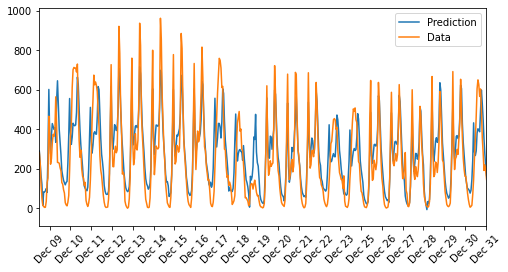

In [73]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = model.__call__(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(left=0, right=len(predictions))
ax.legend()

dates = pd.to_datetime(raw_df.iloc[test_data[1200:].index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)